In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from upsetplot import UpSet, from_memberships
import matplotlib
import warnings 
from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


def load_data(file_path):
    try:
        with open(file_path, 'r') as f:
            for line in f:
                if line.startswith('#'):
                    header_line = line[1:].strip()
                    columns = header_line.split('\t')
                    break
            else:
                raise ValueError(f"No header line found in {file_path}")
        
        df = pd.read_csv(file_path, sep='\t', header=None, names=columns, comment='#')
        
        if 'Me' not in df.columns or 'Un' not in df.columns:
            raise ValueError(f"'Me' or 'Un' columns not found in {file_path}")

        df['meth'] = df['Me'] / (df['Me'] + df['Un'])
        df = df[(df['meth'] > 0) & (df['meth'] < 1)]
        
        if 'JSD_bit_' not in df.columns:
            print(f"'JSD_bit_' column not found in {file_path}. Continuing without it.")
            df['JSD_bit_'] = None  # or handle as needed
        
        return df
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return pd.DataFrame()

base_path = "/shares/grossniklaus.botinst.uzh/dkt/projects/meth1001_code_DKT/analysis/18_jsd_temp/output/"

def process_files(directory):
    dir_path = os.path.join(base_path, directory)
    
    if not os.path.exists(dir_path):
        print(f"Directory {dir_path} does not exist. Skipping.")
        return pd.DataFrame()
    
    file_paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.txt')]
    
    if len(file_paths) == 0:
        print(f"No .txt files found in {dir_path}. Skipping.")
        return pd.DataFrame()
    
    data_frames = [load_data(file) for file in file_paths]
    combined_data = pd.concat(data_frames, ignore_index=True)
    
    return combined_data

def plot_jsd_by_context_and_temperature(combined_data_dict, output_dir):
    combined_data = pd.concat(combined_data_dict.values(), ignore_index=True)
    
    context_temp_pairs = []
    for key in combined_data_dict.keys():
        context, temp = key.split('_')
        df = combined_data_dict[key].copy()
        df['context'] = context
        df['temperature'] = temp
        context_temp_pairs.append(df)
    
    plot_data = pd.concat(context_temp_pairs, ignore_index=True)
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='temperature', y='JSD_bit_', hue='context', data=plot_data)
    
    plt.title("JSD Values by Context Type and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("JSD (bit)")
    plt.legend(title="Context Type")
    
    output_file = os.path.join(output_dir, "jsd_by_context_and_temperature.png")
    plt.savefig(output_file)
    plt.close()
    print(f"Plot saved to: {output_file}")

def plot_combined_jsd_heatmap(combined_data_dict, output_dir, bin_size=10000):
    combined_data_list = []

    for key, df in combined_data_dict.items():
        context, temp = key.split('_')
        if 'JSD_bit_' not in df.columns:
            print(f"Warning: 'JSD_bit_' column not found in data for {key}. Skipping this dataset.")
            continue
        df['context'] = context
        df['temperature'] = temp
        combined_data_list.append(df)
    
    if not combined_data_list:
        print("No valid data to plot. Exiting.")
        return
    
    combined_data = pd.concat(combined_data_list, ignore_index=True)
    
    combined_data['start_bin'] = (combined_data['start'] // bin_size) * bin_size
    combined_data['end_bin'] = (combined_data['end'] // bin_size) * bin_size
    
    try:
        binned_data = combined_data.groupby(['context', 'start_bin', 'end_bin'])['JSD_bit_'].mean().reset_index()
    except KeyError as e:
        print(f"Error during groupby operation: {e}")
        return
    
    try:
        pivot_table = binned_data.pivot_table(index='start_bin', columns='end_bin', values='JSD_bit_', aggfunc='mean')
        
        plt.figure(figsize=(14, 12))
        sns.heatmap(pivot_table, cmap="inferno", cbar_kws={'label': 'JSD (bit)'})
        plt.title("Combined Heatmap of All Context Types and JSD Values")
        plt.xlabel('End (binned)')
        plt.ylabel('Start (binned)')
        
        output_file = os.path.join(output_dir, "combined_jsd_heatmap.png")
        plt.savefig(output_file)
        plt.close()
        print(f"Combined heatmap saved to: {output_file}")
    except KeyError as e:
        print(f"Error creating heatmap: {e}")

def plot_phase_plane(combined_data_dict, output_dir):
    sns.set(style='ticks')
    sns.set_context('talk')
    
    for key, data in combined_data_dict.items():
        if data.empty:
            print(f"No data available for {key}. Skipping plot.")
            continue
        
        if 'JSD_bit_' not in data.columns or 'meth' not in data.columns:
            print(f"'JSD_bit_' or 'meth' column not found in data for {key}. Skipping plot.")
            continue
        
        context, temp = key.split('_')
        title = f"{temp} {context}"
        
        # Use the viridis color palette
        cmap = sns.color_palette("viridis", as_cmap=True)
        
        # Create a joint plot with hexbin for the distribution
        plt.figure(figsize=(10, 8))
        g = sns.jointplot(x='meth', y='JSD_bit_', data=data, kind='hex', 
                          cmap=cmap, joint_kws=dict(gridsize=100))
        
        # Setting title and labels
        g.fig.suptitle(title, y=1.03)  # Adjust the title position
        g.set_axis_labels('Methylation (%)', 'JSD (bit)')
        
        # Save the plot to the specified output directory
        output_file = os.path.join(output_dir, f"{key}_phase_plane.png")
        g.savefig(output_file)
        plt.close()
        print(f"Plot saved to: {output_file}")


def plot_combined_jsd_clustermap(combined_data_dict, output_dir, bin_size=10000):
    combined_data_list = []

    for key, df in combined_data_dict.items():
        context, temp = key.split('_')
        if 'JSD_bit_' not in df.columns:
            print(f"Warning: 'JSD_bit_' column not found in data for {key}. Skipping this dataset.")
            continue
        df['context'] = context
        df['temperature'] = temp
        combined_data_list.append(df)
    
    if not combined_data_list:
        print("No valid data to plot. Exiting.")
        return
    
    combined_data = pd.concat(combined_data_list, ignore_index=True)
    
    # Binning the start positions
    combined_data['start_bin'] = (combined_data['start'] // bin_size) * bin_size
    
    # Pivot the table to have files (context-temperature) as rows and bins as columns
    pivot_table = combined_data.pivot_table(index=['context', 'temperature'], 
                                            columns='start_bin', 
                                            values='JSD_bit_', 
                                            aggfunc='mean')
    
    # Remove any columns or rows with only NaN values
    pivot_table.dropna(axis=0, how='all', inplace=True)
    pivot_table.dropna(axis=1, how='all', inplace=True)
    
    if pivot_table.empty:
        print("No valid data to plot after cleaning. Exiting.")
        return

    try:
        # Generate the clustermap
        sns.clustermap(pivot_table, cmap="inferno", cbar_kws={'label': 'JSD (bit)'}, 
                       standard_scale=1, figsize=(14, 12))
        
        plt.title("Clustered Heatmap of JSD Values by Context and Temperature")
        output_file = os.path.join(output_dir, "jsd_clustermap.png")
        plt.savefig(output_file)
        plt.close()
        print(f"Clustermap saved to: {output_file}")
    except Exception as e:
        print(f"Error creating clustermap: {e}")


In [3]:
import os

output_dir = "shannon/temperatureComp/plots"
os.makedirs(output_dir, exist_ok=True)

combined_data_dict = {}

for temp in ["10C", "16C", "22C"]:
    print(f"\nProcessing data for temperature: {temp}")
    
    for context in ["CHG", "CpG", "CHH"]:
        dir_name = f"{context}_{temp}"
        print(f"Processing directory: {dir_name}")
        
        context_data = process_files(dir_name)
        combined_data_dict[f"{context}_{temp}"] = context_data




Processing data for temperature: 10C
Processing directory: CHG_10C
Processing directory: CpG_10C
Processing directory: CHH_10C

Processing data for temperature: 16C
Processing directory: CHG_16C
Processing directory: CpG_16C
Processing directory: CHH_16C

Processing data for temperature: 22C
Processing directory: CHG_22C
Processing directory: CpG_22C
Processing directory: CHH_22C


In [17]:
plot_jsd_by_context_and_temperature(combined_data_dict, output_dir)

KeyboardInterrupt: 

In [6]:
plot_combined_jsd_heatmap(combined_data_dict, output_dir)

Combined heatmap saved to: shannon/temperatureComp/plots/combined_jsd_heatmap.png


Plot saved to: shannon/temperatureComp/plots/CHG_10C_phase_plane.png
Plot saved to: shannon/temperatureComp/plots/CpG_10C_phase_plane.png


KeyboardInterrupt: 

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

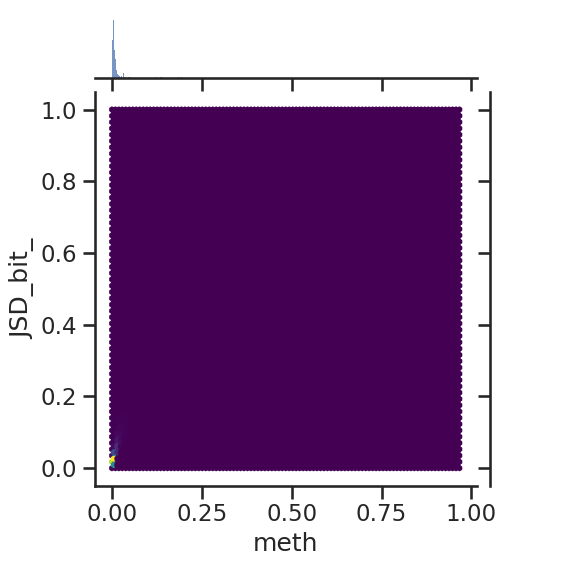

In [18]:
plot_phase_plane(combined_data_dict, output_dir)

# Upset Plot

/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the orig

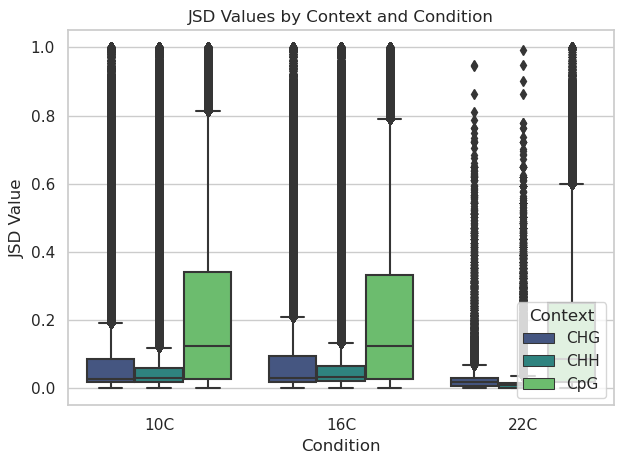

<Figure size 800x600 with 0 Axes>

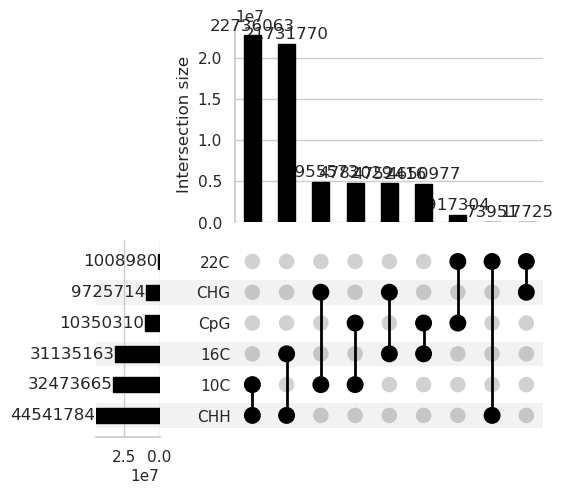

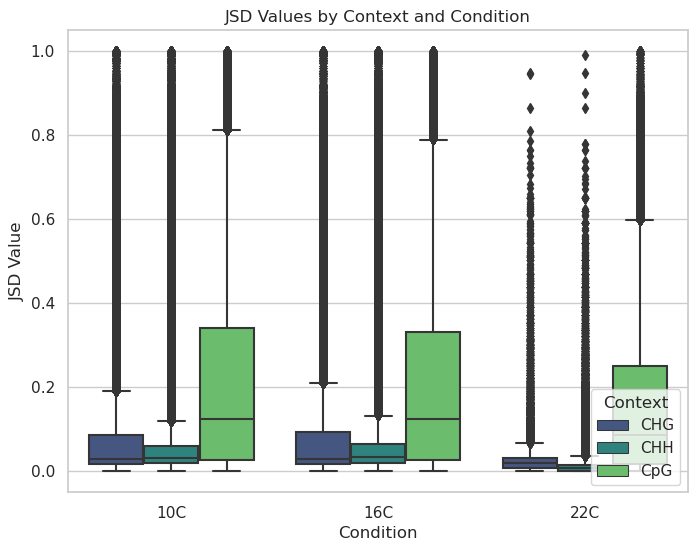

In [26]:
import pandas as pd
from itertools import product

dfs = []

for key, df in combined_data_dict.items():
    context, temperature = key.split('_')
    df['Context'] = context
    df['Condition'] = temperature
    dfs.append(df[['JSD_bit_', 'Context', 'Condition']])

long_df = pd.concat(dfs)

long_df['Presence'] = 1
wide_df = long_df.pivot_table(index='Context', columns='Condition', values='Presence', aggfunc='max').fillna(0).reset_index()

data_long = pd.melt(wide_df, id_vars='Context', value_vars=wide_df.columns[1:], var_name='Condition', value_name='Presence')
data_long = data_long[data_long['Presence'] == 1].drop(columns='Presence')

merged_df = pd.merge(data_long, long_df, on=['Context', 'Condition'], how='left')




In [27]:
conditions = wide_df.columns[1:].tolist()
merged_df['Membership'] = list(zip(merged_df['Context'], merged_df['Condition']))
memberships = [tuple(sorted(set(members))) for members in merged_df['Membership']]
jsd_values = merged_df['JSD_bit_']

upset_data = from_memberships(memberships, data=jsd_values)

sns.set(style="whitegrid")
boxplot = (
    sns.boxplot(data=merged_df, x='Condition', y='JSD_bit_', hue='Context', palette='viridis')
)
boxplot.set(title="JSD Values by Context and Condition", xlabel="Condition", ylabel="JSD Value")
boxplot_figure = boxplot.get_figure()
boxplot_figure.tight_layout()


plt.figure(figsize=(8, 6))
upset = UpSet(upset_data, subset_size='count', show_counts=True, sort_by='cardinality')
upset.plot()


plt.figure(figsize=(8, 6))
sns.boxplot(data=merged_df, x='Condition', y='JSD_bit_', hue='Context', palette='viridis')
plt.title("JSD Values by Context and Condition")
plt.xlabel("Condition")
plt.ylabel("JSD Value")
plt.show()

KeyboardInterrupt: 

In [ ]:

def plot_phase_plane_subplots(combined_data_dict):
    sns.set(style='ticks')
    sns.set_context('talk')
    
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18), constrained_layout=True)
    
    temps = ['10C', '16C', '22C']
    contexts = ['CHG', 'CpG', 'CHH']
    
    for i, temp in enumerate(temps):
        for j, context in enumerate(contexts):
            key = f"{context}_{temp}"
            data = combined_data_dict.get(key, pd.DataFrame())
            
            if data.empty or 'JSD_bit_' not in data.columns or 'meth' not in data.columns:
                axes[i, j].text(0.5, 0.5, f'No data\nfor {context} at {temp}',
                                ha='center', va='center', fontsize=14, color='red')
                axes[i, j].set_axis_off()
                continue
            
            # Plot the hexbin jointplot
            sns.histplot(x='meth', y='JSD_bit_', data=data, bins=100, pthresh=0.1,
                         cmap='viridis', ax=axes[i, j])
            axes[i, j].set_title(f"{context} at {temp}")
            axes[i, j].set_xlabel('Methylation (%)')
            axes[i, j].set_ylabel('JSD (bit)')
    
    for ax in axes.flat:
        ax.label_outer()  
    
    plt.show()


In [ ]:

plot_phase_plane_subplots(combined_data_dict)


In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

def create_jsd_comparison_heatmap(combined_data_dict, output_dir):
    jsd_vectors = {}
    for key, df in combined_data_dict.items():
        if not df.empty:
            jsd_vectors[key] = df['JSD_bit_'].values
    
    jsd_df = pd.DataFrame(jsd_vectors).fillna(0)  
    distance_matrix = pdist(jsd_df.T, metric='correlation')
    distance_matrix_square = squareform(distance_matrix)
    linkage_matrix = linkage(distance_matrix, method='average')
    
    plt.figure(figsize=(12, 10))
    sns.clustermap(jsd_df.corr(), row_cluster=True, col_cluster=True, 
                   method='average', cmap='RdBu_r', linewidths=.5)
    
    plt.title("Heatmap of JSD Comparisons Across Context and Temperature")
    
    output_file = os.path.join(output_dir, "jsd_comparison_heatmap.png")
    plt.savefig(output_file)
    plt.close()
    print(f"Heatmap saved to: {output_file}")

output_dir = "shannon/temperatureComp/plots"
os.makedirs(output_dir, exist_ok=True)
create_jsd_comparison_heatmap(combined_data_dict, output_dir)


ValueError: All arrays must be of the same length

In [6]:
combined_data_dict

{'CHG_10C':         chrom     start       end  JSD_bit_  sample size  HMIX_bit_   Me   Un  \
 0           1        32        32     0.463           91      0.993   28   23   
 1           1        34        34     0.210           91      0.840   53  144   
 2           1       108       108     0.457           91      0.992  122  150   
 3           1       114       114     0.281           91      0.879   93  219   
 4           1       117       117     0.161           91      0.863  155  387   
 ...       ...       ...       ...       ...          ...        ...  ...  ...   
 4955568     5  26975268  26975268     0.311           91      1.000  158  157   
 4955569     5  26975271  26975271     0.321           91      0.941   74  133   
 4955570     5  26975274  26975274     0.297           91      0.963  203  128   
 4955571     5  26975276  26975276     0.410           91      0.825  152   53   
 4955572     5  26975388  26975388     0.407           91      0.891   66  148   
 
   